In [1]:
import numpy as np
import pandas as pd
import sys, os
os.chdir('../')
from pathwaycca.constrained_cca import solve_ccca,ccca
from pathwaycca.significance_test import calculate_p_value_ccca

In [2]:
input_path = "input_data/BRCA_subset/"
gene = "TP53"
X_input = pd.read_csv(f"{input_path}X_input_{gene}.csv", index_col=0)
Y_exp = pd.read_csv(f"{input_path}Full_Y_exp_subset.csv", index_col=0)
all_pathway_genes = pd.read_csv(f"input_data/pathway_db/msigdb_H_P53.csv")

In [3]:
pathway = "HALLMARK_P53_PATHWAY"
gene_list = all_pathway_genes.loc[all_pathway_genes["Pathway"] == pathway, "ENSG_ID"].tolist()
Y_input = Y_exp.loc[:,Y_exp.columns.intersection(gene_list)]
if Y_input.empty or Y_input.shape[1] < 2:
    print(f"Skipping {pathway} due to insufficient data")
X_input = X_input.iloc[:,:-1]
print(f"\nCurrent pathway: {pathway}")
print(f"Dimensions of X_input: {X_input.shape}")
print(f"Dimensions of Y_input: {Y_input.shape}")



Current pathway: HALLMARK_P53_PATHWAY
Dimensions of X_input: (705, 7)
Dimensions of Y_input: (705, 195)


In [4]:
n, p = X_input.shape
m = 4  # number of subtype dummy variables
sub_cols = list(range(p - m, p))  # last m columns are subtype dummy columns

# Equal coefficient constraints
C = np.zeros((m - 1, p))
for r in range(m - 1):
    C[r, sub_cols[r]]   =  1.0
    C[r, sub_cols[r+1]] = -1.0

d = np.zeros(m-1)

In [5]:
lambda_x = 0.05
lambda_y = 0.05
k=4
res = ccca(X_input, Y_input,
    lambda_x=lambda_x,
    lambda_y=lambda_y,
     C=C,
     d=d,
    n_components=k)

In [6]:
np.random.seed(42)
cache_dir = "interm/cache/CCCA_random_pathway_results/"
n_perm = 999
observed_corr = res["r"]
p_val_res = calculate_p_value_ccca(X_input, Y_input, 
                       Y_exp, C, d, observed_corr, n_perm=n_perm, lambda_x=lambda_x, lambda_y=lambda_y,
                       cache_base=cache_dir, file_name="test_TP53",
                       n_components = k,i_choice = 0)
p_val_res

Loading cached permutation statistics from interm/cache/CCCA_random_pathway_results/test_TP53/Ysize_195_nperm_999_lx_0.05_ly_0.05.npy


{'stat0': 0.5897542100054369,
 'p_value': 0.029152848718691615,
 'n_perm': 999,
 'mu': 0.5238782345444071,
 'sigma': 0.034792562484265,
 'i': 0}

In [7]:
from pathwaycca.plot_cca import plt_cca

<Axes: title={'center': 'CCA Variable Correlation Circle Plot'}, xlabel='Dimension 1', ylabel='Dimension 2'>

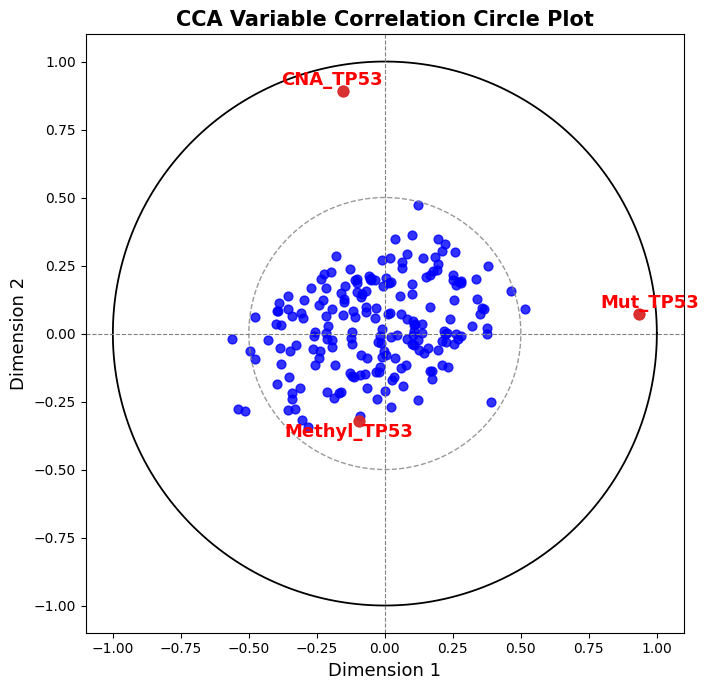

In [10]:
U = res['U']
V = res['V']
plt_cca(U,V,X_input,Y_input,mode = "v",remove_last_xcols=4,Xnames = X_input.columns,title_v="CCA Variable Correlation Circle Plot")